## 「ヒューマノイドロボット」の本に記載されているプログラム

「ヒューマノイドロボット」の本に記載されているプログラムはMatlab形式で，無料のOctaveでも実行が可能であるが，Pythonのプログラムでも確認できるようにできないかと考えてPythonの練習も兼ねて移植してみました．

### データ構造の定義
ヒューマノイドロボットの本と同じくpythonのclassでuLINKの構造を定義する．

下記のデータ構造の例は，「ヒューマノイドロボット」の第２章の例と同じく「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」を加えている．


In [1]:
class uLINK:
  def __init__(self, name, sister, child, m, mother):
    self.name = name
    self.sister = sister
    self.child = child
    self.m = m
    self.mother = mother

上記のクラスを使ってリスト構造にデータを代入する．

初期化では，２分木の構造の兄弟（姉妹）と子供のリンク構造だけ与えておき，リンクの親についてはゼロを代入している．

親リンクについては，後にあるFindmotherの関数で自動的に代入されるようになっている．

In [2]:
arr=[0]*10 #10個のリストをゼロで初期化
arr[0]=uLINK("empty",0,0,0,0) #uLINKクラスの定義に沿ってデータを代入
arr[1]=uLINK("BODY",0,2,10,0)
arr[2]=uLINK("RARM",4,3,5,0)
arr[3]=uLINK("RHAND",0,0,1,0)
arr[4]=uLINK("LARM",6,5,5,0)
arr[5]=uLINK("LHAND",0,0,1,0)
arr[6]=uLINK("RLEG",8,7,6,0)
arr[7]=uLINK("RFOOT",0,0,2,0)
arr[8]=uLINK("LLEG",0,9,6,0)
arr[9]=uLINK("LFOOT",0,0,2,0)

### FindMther関数

兄弟と子供のリンク構造を定義しておけば，この関数を使うことで，リンクの親の情報を求めることができる．

In [3]:
def FindMother(j):
    if j != 0:
        if j == 1:
            arr[j].mother = 0;
        if arr[j].child != 0:
            arr[arr[j].child].mother = j;
            FindMother(arr[j].child);
        if arr[j].sister != 0:
            arr[arr[j].sister].mother = arr[j].mother;
            FindMother(arr[j].sister);

下記は，FindMother関数の実行例

FindMother関数の引数に与えたリンク番号の下に位置している兄弟リンクと子供リンクのすべての親のIDをリンク構造の定義motherに代入してくれる．

In [4]:
FindMother(1) #ID1以下のリンクの親のIDを登録
print("arr[8].mother: ", arr[8].mother) #リンク8の親のIDを表示

arr[8].mother:  1


### TotalMass関数

引数に与えたリンク番号以下のリンク構造すべての質量の和を計算する．

In [5]:
def TotalMass(x):
  if x == 0:
    m = 0
    return m
  else:
    m = arr[x].m + TotalMass(arr[x].sister) + TotalMass(arr[x].child)
    return m

In [6]:
TotalMass(1) #リンク１以下のすべての質量の和．

38

### PrintLinkName関数

引数に与えたリンク番号以下のリンク番号と名前を表示する関数．再帰関数を使って自分のリンクの子供と兄弟のリンクの名前を呼び出すことで指定したリンク以下の名前が表示されるようになっている．ただし，最初のIDの付け方を間違えると無限ループするので注意が必要．この関数を実行することで，きちんとリンクのつながりを定義できているか確認することができる．

In [7]:
def PrintLinkName(j):
    if j != 0:
        print('ID=', j, arr[j].name)
        PrintLinkName(arr[j].child);
        PrintLinkName(arr[j].sister);
    

In [8]:
PrintLinkName(1) #リンク１以下のすべてのリンク番号と名前を表示

ID= 1 BODY
ID= 2 RARM
ID= 3 RHAND
ID= 4 LARM
ID= 5 LHAND
ID= 6 RLEG
ID= 7 RFOOT
ID= 8 LLEG
ID= 9 LFOOT


### Rodriges関数

ロドリゲスの式を使った回転行列の計算を行うための関数．
入力は，第１引数に回転ベクトル（回転軸を表す単位ベクトル），第２引数に回転軸周りに回転した角度を与えることで，回転行列を得ることができる．

In [9]:
def Rodrigues(w,dt):
    norm_w = np.linalg.norm(w);
    if norm_w < sys.float_info.epsilon :
        R = np.eye(3);
    else :
        th = norm_w * dt;
        wn = w/norm_w;
        w_wedge = np.array([ [0, -wn[2], wn[1]],[wn[2], 0, -wn[0]],[-wn[1], wn[0], 0]]);
        R = np.eye(3) + w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1-math.cos(th));
    return R

In [10]:
#Rodrigues関数の利用例
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
w=[1.0, 0.0, 0.0]; #回転ベクトルを定義：x軸回りの回転を表す
dt=0.5;            #回転ベクトル周りの回転量(rad)を与える
Rodrigues(w,dt)    #回転行列R(3x3行列)を計算

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.87758256, -0.47942554],
       [ 0.        ,  0.47942554,  0.87758256]])

### ForwardKinematics関数

順運動学の計算を行う関数．引数を与えたリンク以下のすべてのリンクの関節位置を現在の関節角度から計算する．再帰関数を利用しているため非常にシンプルにすべての関節の位置と姿勢（回転行列）を得ることができる．

In [11]:
def ForwardKinematics(j):
    if j == 0: return
    if j != 1:
        mom = arr[j].mother;
        arr[j].p = np.matmul(arr[mom].R, arr[j].b) + arr[mom].p #　絶対座標系の位置に回転行列で戻してから位置を加えていくことで絶対座標系での関節位置を求める
        ROD = Rodrigues(arr[j].a, arr[j].q); #　回転行列をロドリゲスの関数から導く
        arr[j].R = np.matmul(arr[mom].R, ROD); #　一つ手前（親）のリンクの回転行列をかけて，絶対座標系でのリンクの姿勢行列を求める
    ForwardKinematics(arr[j].sister);
    ForwardKinematics(arr[j].child);

### データ構造の定義の追加

一番初めに定義した「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」の他に，順運動学計算に必要となるリンク間距離(b：３次元ベクトル)や関節の回転軸(a：３次元ベクトル)，関節の回転角(q：スカラ)，リンクの回転行列(R：絶対座標基準)，リンクの位置(p：絶対座標基準)を追加している．

In [12]:
class uLINK:
  def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b # リンク間距離（親リンク座標系相対位置でのリンクの長さ）
    self.a = a # 関節軸の方向（親リンク座標系相対の回転ベクトル方向）
    self.q = q # 関節の回転角度
    self.R = R # リンクの姿勢行列（回転行列）：絶対座標基準
    self.p = p # リンクの関節の位置：絶対座標基準

新しく設定した定義に合わせて，リンクの情報の設定例を下記に示す．

右足(RLEG）と左足（LLEG）はそれぞれJ0からJ5の６つの関節を有しているロボットアーム（レッグ）となっている．

股関節（肩関節）に３軸直交（J0のZ軸回転（ヨー）とJ1のX軸回転（ロール），J2のY軸回転（ピッチ）が同じ位置に設定されている）となっており，膝関節はJ3関節にY軸回り（ピッチ）の関節，足首には，J4関節にY軸（ヨー）とJ5関節にX軸（ロール）の関節を与えている．


In [13]:
ToDeg = 180/math.pi;   #r adianからdegreeに変換するときの係数
ToRad = math.pi/180;   #d egreeからradianに変換するときの係数

UX = [1.0,0.0,0.0];    # X軸の単位ベクトルで関節軸を設定するためのシンボル設定
UY = [0.0,1.0,0.0];    # Y軸の単位ベクトルで関節軸を設定するためのシンボル設定
UZ = [0.0,0.0,1.0];    # Z軸の単位ベクトルで関節軸を設定するためのシンボル設定

R0=np.eye(3);          # 単位行列のシンボル設定
p0= [0,0,0];           # ゼロ位置のシンボル設定

arr = [0]*14          # リンクの数（この例では14リンク）の配列を初期化

arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[1]=uLINK("BODY", 0, 2, 0, 10, [0.0, 0.0, 0.7],UZ,0,R0,p0) # Bodyのリンク初期化

# 右足のリンクの初期化：第3関節（股関節のピッチ）と第4関節（膝関節）のピッチ角を与えている）
arr[2]=uLINK("RLEG_J0", 8, 3, 0, 5, [0.0,-0.1, 0.0],UZ,0,R0,p0)
arr[3]=uLINK("RLEG_J1", 0, 4, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[4]=uLINK("RLEG_J2", 0, 5, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[5]=uLINK("RLEG_J3", 0, 6, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[6]=uLINK("RLEG_J4", 0, 7, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[7]=uLINK("RLEG_J5", 0, 0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

# 左足のリンクの初期化：第10関節（股関節のピッチ）と第11関節（膝関節）のピッチ角を与えている）
arr[8] =uLINK("LLEG_J0", 0,  9, 0, 5, [0.0, 0.1, 0.0],UZ,0,R0,p0)
arr[9] =uLINK("LLEG_J1", 0, 10, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[10]=uLINK("LLEG_J2", 0, 11, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[11]=uLINK("LLEG_J3", 0, 12, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[12]=uLINK("LLEG_J4", 0, 13, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[13]=uLINK("LLEG_J5", 0,  0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

FindMother(1)

上記の様に各リンクの設定が適切に行われていれば，ForwardKinematics関数を呼び出すだけで，各関節の位置と姿勢を求めることができる．

下記に使用例を示す．

In [14]:
ForwardKinematics(1) #第１リンク以下のすべてのリンク位置と姿勢を計算
print(arr[7].p)      #第７リンクの関節位置を表示（右足首の位置）
print(arr[7].R)      #第７リンクの関節の姿勢行列を表示（右足首の姿勢行列）
print(arr[13].p)     #第13リンクの関節位置を表示（左足首の位置）
print(arr[13].R)     #第13リンクの関節の姿勢行列を表示（左足首の姿勢行列）

[ 0.3 -0.1 -0.3]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[ 0.3  0.1 -0.3]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


イメージがつきやすいように下記のコードで，3次元のグラフに各関節の位置をプロットして線でつなげた図を示す．

「#inline」をつけることで，プロット図をjupyternotebook上でも見ることができる．

下記では記載していないが「%matplotlib notebook」と記載をしておくと，3次元プロットをドラッグして別の視点からも見ることができる．

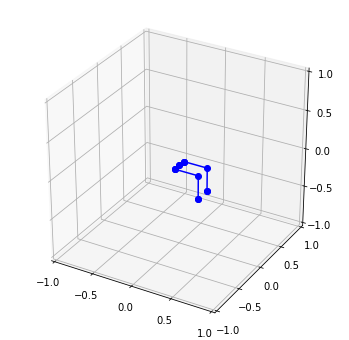

In [15]:
#inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b') # 右足の位置を線で接続したプロット
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b') # 左足の位置を線で接続したプロット
ax.set_xticks(np.linspace(-1.0, 1.0, 5)) # X軸の表示範囲
ax.set_yticks(np.linspace(-1.0, 1.0, 5)) # Y軸の表示範囲
ax.set_zticks(np.linspace(-1.0, 1.0, 5)) # Z軸の表示範囲

plt.show()

## RPY2R関数

roll(X軸回りの回転角），pitch(Y軸回りの回転角），yaw(Z軸回りの回転角）の角度から回転行列R（３ｘ３）を求める関数．


In [16]:
def RPY2R(rpy): # 入力rpyはnumpyのarrayで1行3列のベクトル
    roll = rpy[0]; pitch = rpy[1]; yaw = rpy[2];
    Cphi = math.cos(roll);  Sphi = math.sin(roll);
    Cthe = math.cos(pitch); Sthe = math.sin(pitch);
    Cpsi = math.cos(yaw);   Spsi = math.sin(yaw);

    R = [[Cpsi*Cthe,  -Spsi*Cphi+Cpsi*Sthe*Sphi,  Spsi*Sphi+Cpsi*Sthe*Cphi],
       [Spsi*Cthe,  Cpsi*Cphi+Spsi*Sthe*Sphi,   -Cpsi*Sphi+Spsi*Sthe*Cphi],
       [-Sthe,      Cthe*Sphi,                  Cthe*Cphi]                 ]
    return R


## FindRoute関数

求めたい位置・姿勢のリンクを引数に与えると，Bodyリンクからのリンクのつながり（ルート）を配列で返してくれる．

例えば，引数に右足首の最終関節のリンク番号7を与えるとボディリンク１からどの関節を経由してリンク７につながっているか配列で返してくれる．<br>
FindRoute(7)　と入力すると<br>
[2,3,4,5,6,7]　という配列が返ってくる

In [17]:
def FindRoute(to): # 入力toには経路を知りたいリンクのIDを与える
#return the list of joint number connecting ROOT to 'to'
    i = arr[to].mother;
#if i == 0
#    idx = [];    % search failed
#    fprintf('FindRoute: search failed\n');
#else
    if i == 1:
        idx = [to];
    else:
        idx = FindRoute(i) + [to];
    return idx


In [18]:
FindRoute(7) # 第７リンクまでの関節のつながりを表示 # BodyのID 1から[2,3,4,5,6,7]とつながっていることがわかる

[2, 3, 4, 5, 6, 7]

## 逆運動学１

ヤコビ行列を使った逆運動学の導出．

### rot2omega関数

回転行列R(:３ｘ３行列)から[roll(X軸回りの回転), pitch(Y軸回りの回転), yaw(Z軸回りの回転)]の１行３列のベクトルを算出．単位はradian．

In [19]:
def rot2omega(R):
    # T.Sugihara "Solvability-unconcerned Inverse Kinemacics based on 
    # Levenberg-Marquardt method with Robust Damping," Humanoids 2009
    #el = [R[3,2]-R[2,3], R[1,3]-R[3,1], R[2,1]-R[1,2]];
    el = np.array([R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]);
    norm_el = np.linalg.norm(el);
    if norm_el >  sys.float_info.epsilon :
        #print("el ",el)
        #print("norm_el ",norm_el)
        #print("np.trace(R)", (np.trace(R)-1))
        #print("atan2 ",math.atan2(norm_el, np.trace(R)-1))
        w = math.atan2(norm_el, np.trace(R)-1)/norm_el * el;
    elif R[0,0]>0 and R[1,1]>0 and R[2,2]>0 :#elif R[1,1]>0 and R[2,2]>0 and R[3,3]>0 :
        w = [0, 0, 0];
    else :
        w = math.pi/2*[R(0,0)+1, R(1,1)+1, R(2,2)+1];#w = math.pi/2*[R(1,1)+1, R(2,2)+1, R(3,3)+1];
    return w # [roll, pitch, yaw]の単位はrad

### CalcWerr関数

目標位置・姿勢と現在位置の誤差を算出する関数．

第１引数(arr1)：現在位置・姿勢の６次元ベクトル(x,y,z,roll,pitch,yaw)
第２引数(arr2)：目的位置・姿勢の６次元ベクトル(x,y,z,roll,pitch,yaw)

In [20]:
def CalcVWerr(arr1, arr2):
    perr = arr1.p - arr2.p;
    Rerr = np.matmul(arr2.R.T, arr1.R);
    werr = np.matmul(arr2.R, rot2omega(Rerr));
    #print("rot2omega",rot2omega(Rerr))
    #err = [perr, werr];
    err = [0]*6

    for k in range(3):
        err[k] = perr[k];
        err[k+3] = werr[k];
    return err

### CalcJacobian_rot関数
回転行列だけのヤコビアンを計算する関数．使わないと思うけど一応用意．


In [23]:
def  CalcJacobian_rot(idx) :
    #Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;#   % absolute target position
    J = np.zeros(3,jsize);

    for n in range(jsize):
        j = idx[n];
        a = np.matmul(arr[j].R, arr[j].a);#  % joint axis vector in world frame
        J[:,n] = np.cross(a, target - arr[j].p);
    return J

### CalcJacobian関数
並進と回転のヤコビアンを計算する関数．通常はこちらだけ使う．

引数はリンクID．

引数にIDを与えると，基準のIDから引数に与えたIDまでのヤコビアンの計算をしてくれる．

In [22]:
def CalcJacobian(idx) :
    # Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;   #% absolute target position
    J = np.zeros((6,jsize));
    #JT = np.zeros((jsize,6));

    for n in range(jsize) : #n=1:jsize
        j = idx[n];
        #print("j ", j)
        #print("arr.R ", arr[j].R)
        #print("arr.a ", arr[j].a)
        a = np.matmul(arr[j].R, arr[j].a);  #% joint axis vector in world frame
        #print("cross ", np.cross(a, target - arr[j].p) )
        #print("a ", a)
        cross = np.cross(a, target - arr[j].p);
        #print("len(cross) ", len(cross))
        for k in range(len(cross)):
            J[k, n] = cross[k];
            J[k+len(cross),n] = a[k];

    return J



### InverseKinematics関数
ヤコビ行列を使って，現在位置と目標位置の差のある方向にニュートン法を使って少しずつ動かして目的の位置姿勢へリンク先端を動かす逆行列計算．現在位置と目標位置の差はCalcWerr関数で求める．

引数は第１引数（to）：動かすリンクID，第２引数(Target)：目標位置・姿勢（x,y,z,roll,pitch,yaw)の６次元ベクトル

In [23]:
def InverseKinematics(to, Target):
    lam = 0.9;
    idx = FindRoute(to);
    #print("idx ", idx)
    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
   # print("err ",err)
    for n in range(10):
        if np.linalg.norm(err) < 1e-6 : break;
        J  = CalcJacobian(idx);
        #print("J ", J )
        dq = lam * np.matmul(np.linalg.inv(J), err);
        print("dq ",dq)
        #print("idx ", idx)
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        #print("err ", err)

    err_norm = np.linalg.norm(err);
    return err_norm

In [24]:
def MoveJoints(idx, dq):
    for n in range(len(idx)):
        j = idx[n];
        arr0 = arr[j].q
        arr[j].q = arr[j].q + dq[n];
        #print("arr1, arr0, dq ",arr[n].q , arr0 , dq[n])
    #print("arr_q ", arr[0].q, arr[1].q, arr[2].q, arr[3].q, arr[4].q, arr[5].q)

dq  [ 0.00000000e+00  0.00000000e+00 -1.66533454e-16  9.00000000e-01
 -9.00000000e-01  0.00000000e+00]
dq  [ 0.          0.          0.58628917 -0.27257833 -0.31371083  0.        ]
dq  [ 0.          0.         -0.07047913 -0.08553446  0.15601359  0.        ]
dq  [ 0.          0.          0.00696833 -0.01641588  0.00944755  0.        ]
dq  [ 0.          0.          0.00073797 -0.00168484  0.00094687  0.        ]
dq  [ 0.00000000e+00  0.00000000e+00  7.41937221e-05 -1.68941159e-04
  9.47474370e-05  0.00000000e+00]
dq  [ 0.00000000e+00  0.00000000e+00  7.42332528e-06 -1.68987139e-05
  9.47538867e-06  0.00000000e+00]
dq  [ 0.   0.   0.3  0.6 -0.9  0. ]
dq  [ 0.          0.          0.42904993 -0.38398035 -0.04506958  0.        ]
dq  [ 0.          0.         -0.00436861 -0.09013048  0.09449909  0.        ]
dq  [ 0.          0.          0.00450218 -0.01304728  0.00854509  0.        ]
dq  [ 0.          0.          0.00048934 -0.0013503   0.00086096  0.        ]
dq  [ 0.00000000e+00  0.0000000

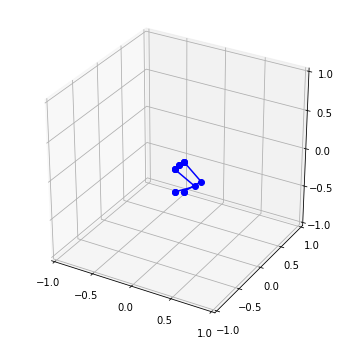

arr[7].p  [-3.41954395e-08 -1.00000000e-01 -2.99999512e-01]
rerr_norm  4.890344147874627e-07
arr[13].p  [-8.18207908e-08  1.00000000e-01 -3.99999663e-01]
lerr_norm  3.4661084445799394e-07


In [25]:
#ヤコビ行列を使った逆運動学計算
#初期姿勢がおかしいと計算できないことがあるので注意
Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
RLEG_J5 = 7;
LLEG_J5 = 13;

Rfoot.p = [0.0, -0.1, -0.3]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4
rerr_norm = InverseKinematics(RLEG_J5, Rfoot);

Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4
lerr_norm = InverseKinematics(LLEG_J5, Lfoot);

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
#inline
plt.show()
print("arr[7].p ", arr[7].p)
print("rerr_norm ", rerr_norm)
print("arr[13].p ", arr[13].p)
print("lerr_norm ", lerr_norm)

In [26]:
def Draw_R(arr):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

    ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
    ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
    ax.set_xticks(np.linspace(-1.0, 1.0, 5))
    ax.set_yticks(np.linspace(-1.0, 1.0, 5))
    ax.set_zticks(np.linspace(-1.0, 1.0, 5))
    #inline
    plt.show()

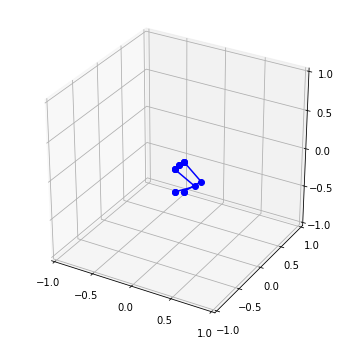

In [27]:
Draw_R(arr)

## 逆運動学２

LM法を使ったロバストな逆運動学の計算．

In [28]:
def SetJointAngles(idx, q):
    for n in range(len(idx)):
        j = idx[n];
        arr[j].q = q[n];
        
    ForwardKinematics(1);

In [29]:

def InverseKinematics_LM(to, Target):
# Levenberg-Marquardt, Chan-Lawrence, Sugihara's modification

    idx = FindRoute(to);
    wn_pos = 1/0.3;
    wn_ang = 1/(2*math.pi);
    We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang]);#何やってる？
    Wn = np.eye(len(idx));#何やってるの？

    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
    Ek = np.matmul(np.matmul(err, We),err); #Ek = err'*We*err;

    for n in range(10):
        J  = CalcJacobian(idx);
        #Jh = J'*We*J + Wn*(Ek + 0.002);  %Hk + wn
        Jh = np.matmul(np.matmul(J.T,We),J) + Wn*(Ek+0.002)
        #gerr = J'*We*err;    %gk
        gerr = np.matmul(np.matmul(J.T, We), err);
        #dq   = Jh \ gerr;    %new
        dq = np.matmul(np.linalg.inv(Jh), gerr);
            
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        Ek2 = np.matmul(np.matmul(err, We),err);
        #print("Ek2 ",Ek2)
        #Ek2 = err'*We*err;
        if Ek2 < 1e-12:
          break;
        elif Ek2 < Ek:
          Ek = Ek2;
        else:
          MoveJoints(idx, -dq);#  % revert
          ForwardKinematics(1);
        break; 
        #end
    #end

    #if nargout == 1 
    err_norm = np.linalg.norm(err);
    #end

    return err_norm

Rfoot  0.0


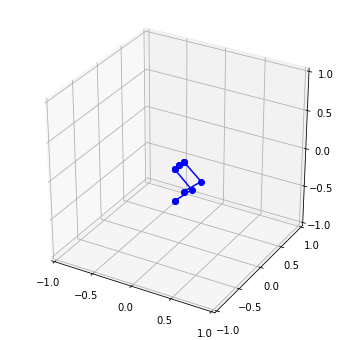

Error  0.03495960199738151


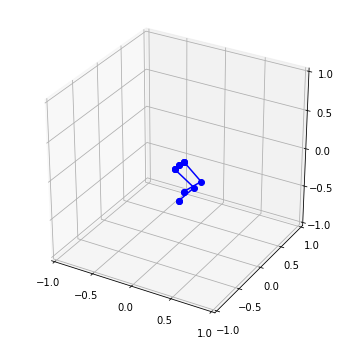

Error  0.00018769500388329577


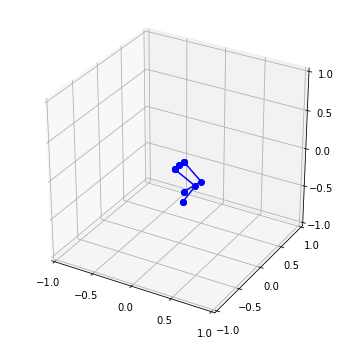

Error  0.00019973604714114364


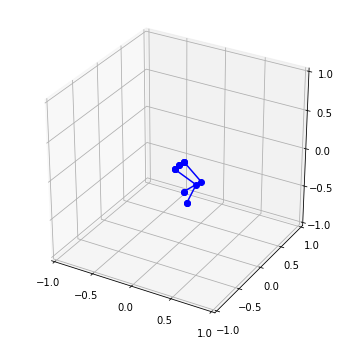

Error  0.00020981188009682432


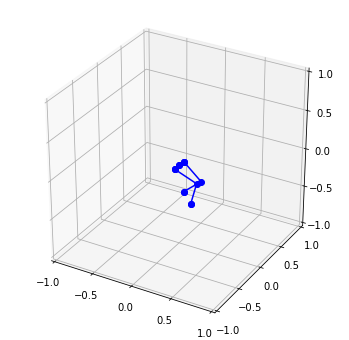

Error  0.00022053649144359935


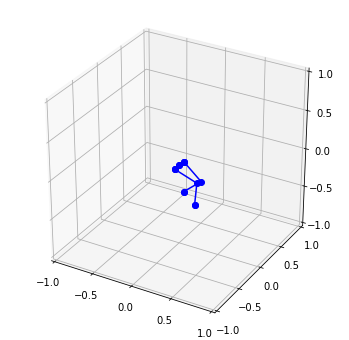

Error  0.0002360270690738549


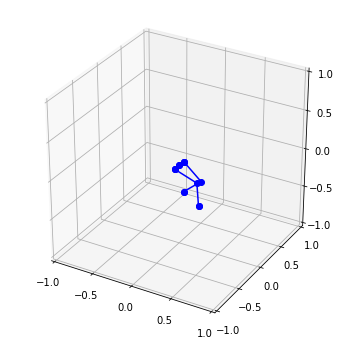

Error  0.00026424757663723666


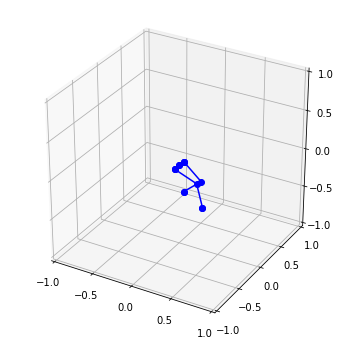

Error  0.00032747839906278843


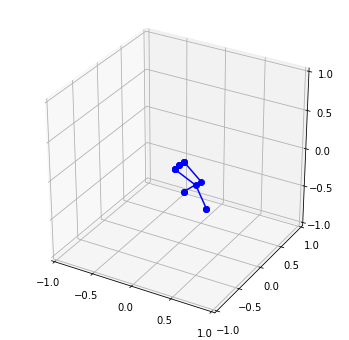

Error  0.0005392232096093528


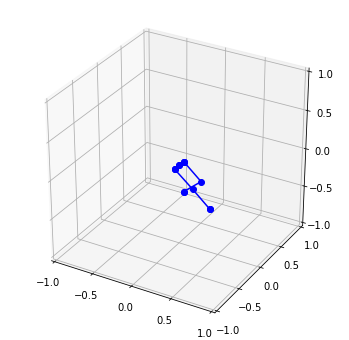

Error  0.00594234208346476


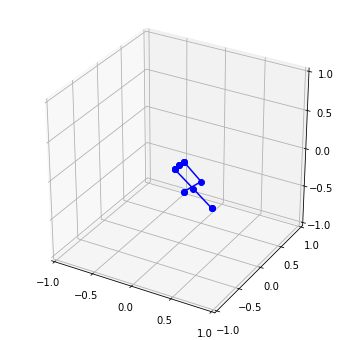

Error  0.044225750085514624


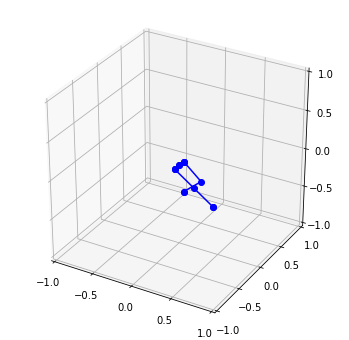

Error  0.08412664263855209


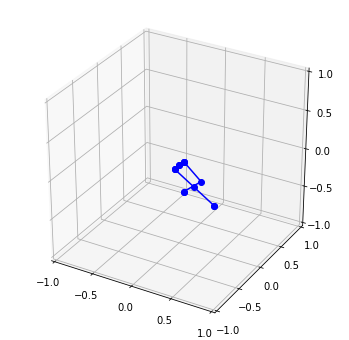

Error  0.12528261830275297


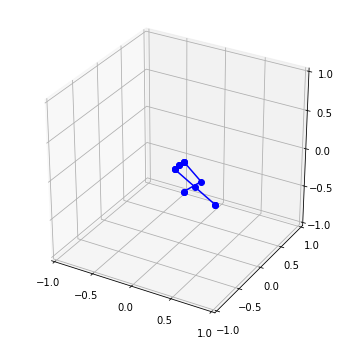

Error  0.1674917239376676


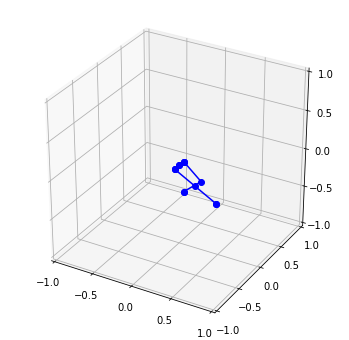

Error  0.21058939918300387


In [30]:
# Numerical inverse kinematics and knee stretch
# ik_stretch_LM.m
# 2013 Sept.23 s.kajita AIST

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

#%%%%%%%%%%% target foot position and orientation %%%%%%%%%%%%
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);

#ここからまだ修正していない
#xd_m = 0:0.005:0.4';
Nstep = 150 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　% Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';      %%% Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        Draw_R(arr);
        print("Error ", rerr_norm);





Rfoot  0.0
Error  0.03495960199738151
Error  0.00018769500388329577
Error  0.00019973604714114364
Error  0.00020981188009682432
Error  0.00022053649144359935
Error  0.0002360270690738549
Error  0.00026424757663723666
Error  0.00032747839906278843
Error  0.0005392232096093528
Error  0.00594234208346476


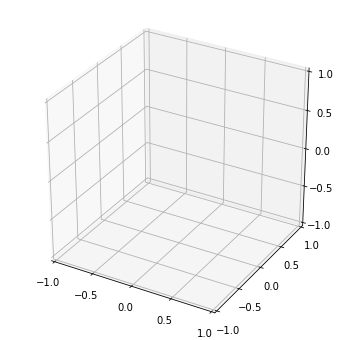

In [31]:
# ik_strechのgifアニメーションセーブバージョン

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

#%%%%%%%%%%% target foot position and orientation %%%%%%%%%%%%
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#  %  -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);


#xd_m = 0:0.005:0.4';
Nstep = 100 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

data = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

ims = []

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])


for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　% Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);

    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
    data = np.vstack((data,r_leg));
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';      %%% Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        #Draw_R(arr);
        #Gen_R(arr);
        r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
        l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
        im1, = ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
        im2, = ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
        ims.append([im1,im2])
        print("Error ", rerr_norm);
        
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('anim.gif', writer="pillow")
#ani.save('anim.mp4', writer="ffmpeg") # 動画はこちらをコメントアウトを外せば作成できる
plt.show()

## 動力学

動力学の計算を行う．

In [32]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
arr=[0]*10

In [33]:
#For Dynamic simulation dvo, w, vo　追加
class uLINK:
  def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, w, vo, dw, dvo):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b
    self.a = a
    self.q = q
    self.R = R
    self.p = p
    self.dq =dq
    self.ddq = ddq
    self.c  = c
    self.I  = I
    self.u  = u
    self.w = w 
    self.vo = vo 
    self.dw = dw 
    self.dvo = dvo

In [34]:
def MakeRigidBody(j, wdh, mass):
    arr[j].m = mass;
    arr[j].c = [0, 0, 0];
    arr[j].I = np.array([[1/12*(wdh[1]*wdh[1] + wdh[2]*wdh[2]), 0.0, 0.0],
            [0.0, 1/12*(wdh[0]*wdh[0] + wdh[2]*wdh[2]),  0.0],
            [0.0, 0.0, 1/12*(wdh[0]*wdh[0] + wdh[1]*wdh[1])]]) * mass;
    arr[j].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
    for n in range(3):
        for i in range(8):
            arr[1].vertex[i,n] = arr[1].vertex[i,n] - wdh[n]/2;
        
    arr[j].face = [
        [1, 2, 3, 4], [2, 6, 7, 3], [4, 3, 7, 8],
        [1, 5, 8, 4], [1, 2, 6, 5], [5, 6, 7, 8]
        ];

In [35]:
def EulerDynamics(j):
    I = np.matmul(np.matmul(arr[j].R, arr[j].I), arr[j].R.T); #    % 慣性テンソル
    L = np.matmul(I, arr[j].w);   # 角運動量
    arr[j].dw  = -np.matmul(np.linalg.inv(I), np.cross(arr[j].w, L)); #   % Eulerの方程式
    return L

In [36]:
def ShowObject(arr):
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    #ax.set_xticks(np.linspace(AX[0], AX[1], 5))
    #ax.set_yticks(np.linspace(AY[0], AY[1], 5))
    #ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
    ax.set_xticks(np.linspace(AX[0]+arr[BODY].p[0], AX[1]+arr[BODY].p[0], 5))
    ax.set_yticks(np.linspace(AY[0]+arr[BODY].p[1], AY[1]+arr[BODY].p[1], 5))
    ax.set_zticks(np.linspace(AZ[0]+arr[BODY].p[2], AZ[1]+arr[BODY].p[2], 5))
    #ims.append(im);
    plt.show()


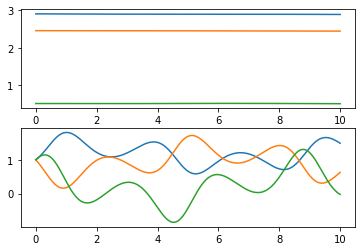

In [37]:
#rigidbody_rotate.m
lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)
boxsize=np.array([lx, ly, lz]);
MakeRigidBody(1, boxsize, mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      #% 初期角速度 [rad/s]
Dtime   = 0.001; #0.001s(1ms)にしないと本と同じような結果にはならない．サンプルプログラムは0.02s(20ms)だとかなり誤差が発生する．
EndTime = 10.0;

time  = int(EndTime//Dtime)+1;

L_w = np.zeros([time,3])
w_w = np.zeros([time,3])

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];

for n in range(time):
    L_w[n,:] = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    w_w[n,:] = arr[1].w;
    #print(arr[1].R)
    #ShowObject(arr);  # 姿勢を描画．

times = np.arange(0,EndTime,Dtime)
fig = plt.figure();
ax = fig.add_subplot(2, 1, 1) # 角運動量保存を確認するための図(サンプリングタイムを1msぐらいにしないと精度は悪い)
ax.plot(times, L_w[:,0])
ax.plot(times, L_w[:,1])
ax.plot(times, L_w[:,2])
ax = fig.add_subplot(2, 1, 2) # 各軸の角速度の変化
ax.plot(times, w_w[:,0])
ax.plot(times, w_w[:,1])
ax.plot(times, w_w[:,2])
plt.show()

250


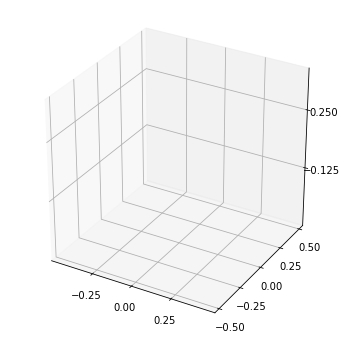

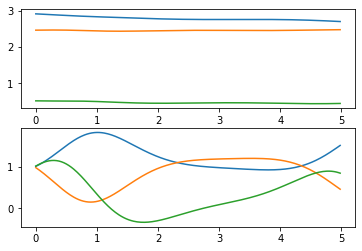

In [38]:
#rigidbody_rotate.m アニメーション出力
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

ims =[]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

MakeRigidBody(1, [lx, ly, lz], mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      #% 初期角速度 [rad/s]
Dtime   = 0.02;
EndTime = 5.0;

time  = int(EndTime//Dtime)+1;
print(time)

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];
L_w = np.zeros([time,3])
w_w = np.zeros([time,3])

for n in range(time):
    L_w[n,:] = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    w_w[n,:] = arr[1].w;
    #print(arr[1].R)
    
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex


    im = ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ims.append(im)
    

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('rotate.gif', writer="pillow")
plt.show()

times = np.arange(0,EndTime,Dtime)
fig = plt.figure();
ax = fig.add_subplot(2, 1, 1)
ax.plot(times, L_w[:,0])
ax.plot(times, L_w[:,1])
ax.plot(times, L_w[:,2])
ax = fig.add_subplot(2, 1, 2)
ax.plot(times, w_w[:,0])
ax.plot(times, w_w[:,1])
ax.plot(times, w_w[:,2])
plt.show()
    

In [39]:
start = 50
stop = 100
step = 2
np.arange(stop)
#0 ≦ n < stopで間隔は1
np.arange(start, stop)
#start ≦ n < stopで間隔は1
np.arange(start, stop, step)
#start ≦ n < stopで間隔はstep

array([50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82,
       84, 86, 88, 90, 92, 94, 96, 98])

## 順運動学

単位ベクトル法による順運動学の計算．単一剛体の並進と回転の運動をシミュレーションするプログラム．

In [40]:
def DrawAllJoints(j):
    radius    = 0.02;
    len       = 0.06;
    joint_col = 0;

    if j != 0 : 
        #print("arr.vertex ", arr[j].vertex);
        if arr[j].vertex.any() : #vertexが空じゃなかったら．~isempty(uLINK(j).vertex)
            #print("arr.vertex ", arr[j].vertex);
            vert = np.matmul(arr[j].vertex, arr[j].R);
            for k in range(3): # 1:3
                vert[k,:] = vert[k,:] + arr[j].p[k]; #% adding x,y,z to all vertex
            ShowObject(arr) #DrawPolygon(vert, uLINK(j).face,0);
    
        i = arr[j].mother;
        if i != 0:
            #Connect3D(uLINK(i).p,uLINK(j).p,'k',2);
            #function Connect3D(p1,p2,option,pt)
            #h = plot3([p1(1) p2(1)],[p1(2) p2(2)],[p1(3) p2(3)],option);
            #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
            im=ax.plot([arr[i].p[0],arr[j].p[0]],[arr[i].p[1],arr[j].p[1]],[arr[i].p[2],arr[j].p[2]],"o-", c='b')
            #set(h,'LineWidth',pt)
            ims.append(im)

        #DrawCylinder(uLINK(j).p, uLINK(j).R * uLINK(j).a, radius,len, joint_col);
    
    
        DrawAllJoints(arr[j].child);
        DrawAllJoints(arr[j].sister);


In [41]:
def hat(c):
    c_hat = np.array([[0, -c[2], c[1]], [c[2], 0., -c[0]], [-c[1], c[0], 0.]]);
    return c_hat
    

In [42]:
a = np.array([[1],
              [2],
              [3]])
print(a.reshape([1,3]))
# 形状 (1, 3)
b = np.array([[1, 2, 3]])

c = a @ b
print(c)


[[1 2 3]]
[[1 2 3]
 [2 4 6]
 [3 6 9]]


In [43]:
def SE3exp(j, dt):
#% see Murray, Li, Sastry p.42
    norm_w = np.linalg.norm(arr[j].w);
    if norm_w < sys.float_info.epsilon :
        p2 = arr[j].p + dt * arr[j].vo;
        R2 = arr[j].R;
    else :
        th = norm_w*dt;
        wn = arr[j].w/norm_w;  #		% normarized vector
        vo = arr[j].vo/norm_w;
        #print("norm_w ",norm_w)
        #print("th ",th)
        #print("wn ", wn)
        #print("vo ", vo)
    
        w_wedge = np.array([[0., -wn[2], wn[1]],[wn[2], 0., -wn[0]],[-wn[1], wn[0], 0.]]);
        drot = w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1.0-math.cos(th));
        rot  = np.eye(3) + drot;
        #print("test2 ", wn.reshape([3,1])@wn.reshape([1,3])) # 「＠」は縦ベクトル(3x1)x横ベクトル(1x3)=３ｘ３行列の計算．あと，reshapeも必要．転置では対応できない
        #p2 = np.matmul(rot, arr[j].p) - np.matmul(drot, np.cross(wn,bb vo)) + np.dot(wn, wn.T)* vo * th;
        p2 = np.matmul(rot, arr[j].p) - np.matmul(drot, np.matmul(w_wedge, vo)) + np.matmul(wn.reshape([3,1])@wn.reshape([1,3]), vo) * th;
        R2 = np.matmul(rot, arr[j].R);
        
    return p2, R2

arr.vertex1  [[0.  0.  0. ]
 [0.  0.4 0. ]
 [0.1 0.4 0. ]
 [0.1 0.  0. ]
 [0.  0.  0.9]
 [0.  0.4 0.9]
 [0.1 0.4 0.9]
 [0.1 0.  0.9]]
tsize  33


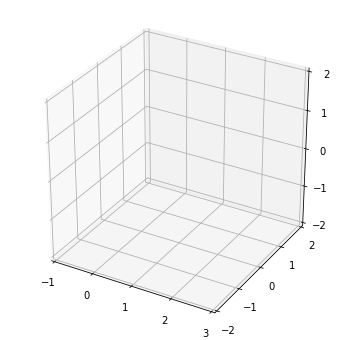

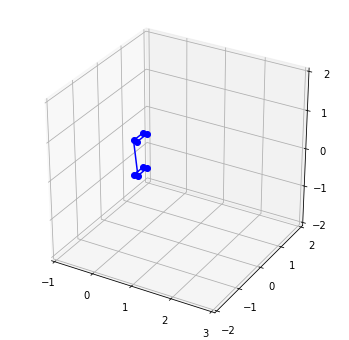

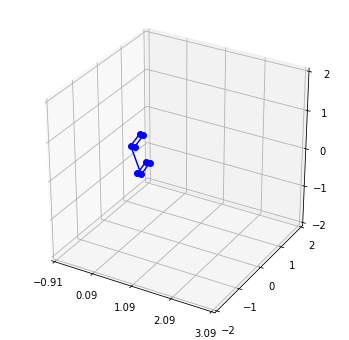

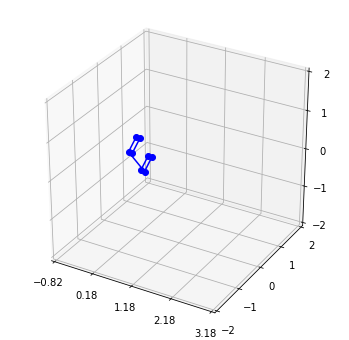

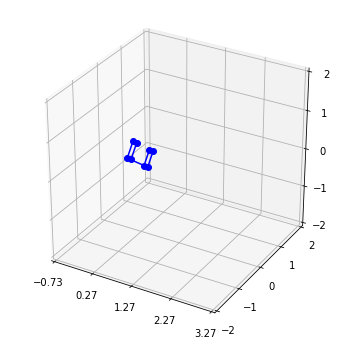

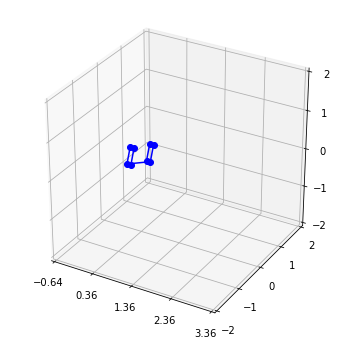

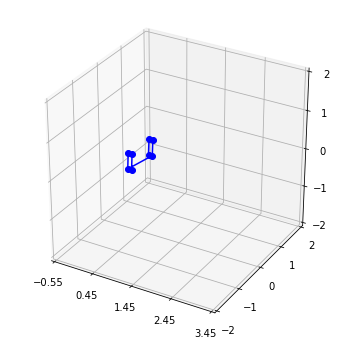

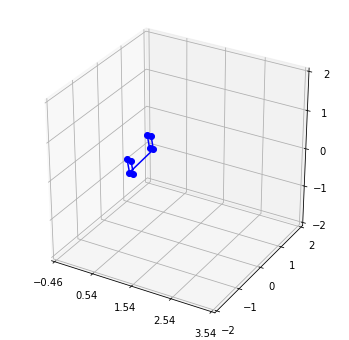

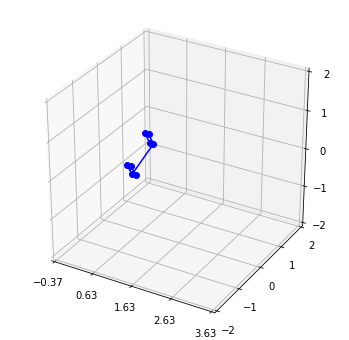

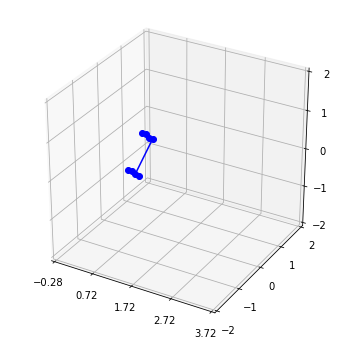

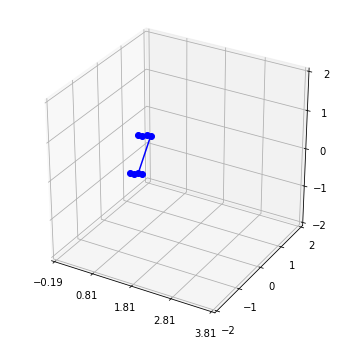

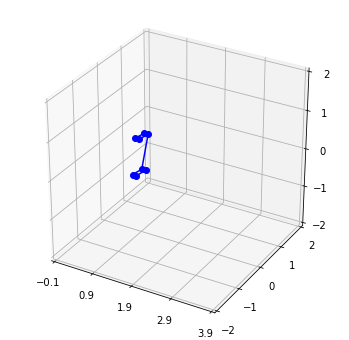

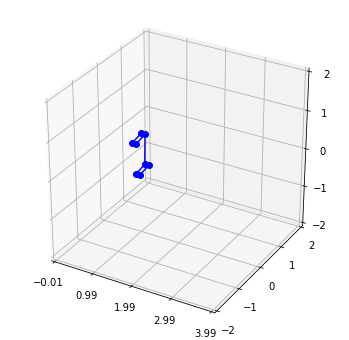

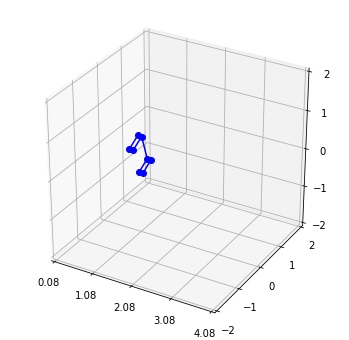

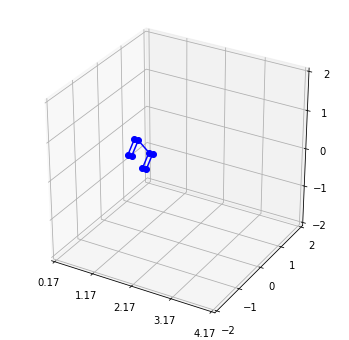

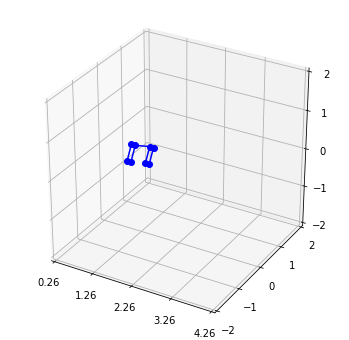

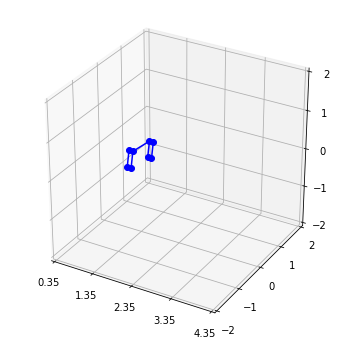

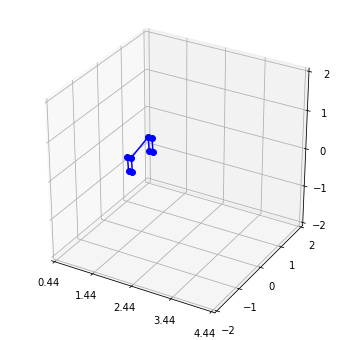

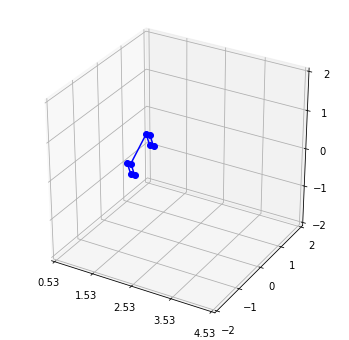

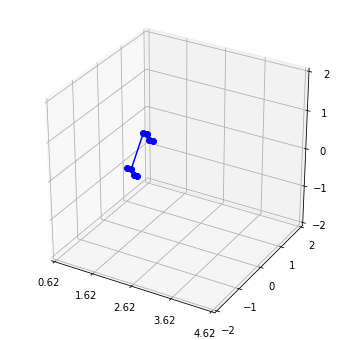

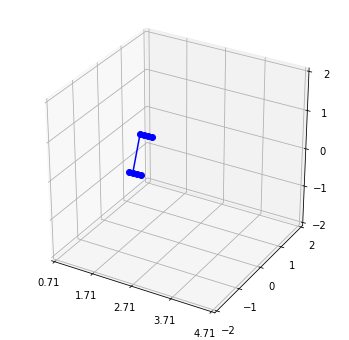

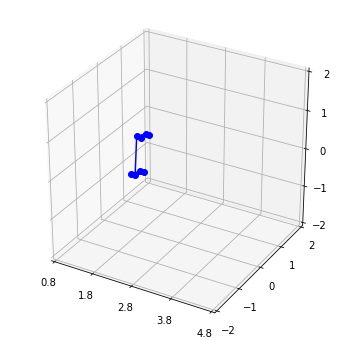

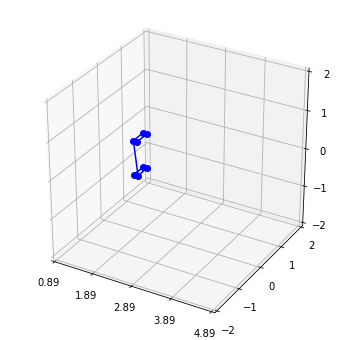

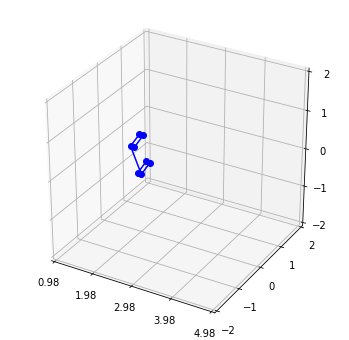

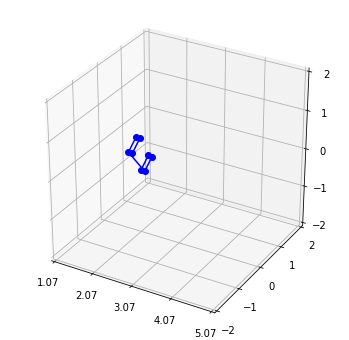

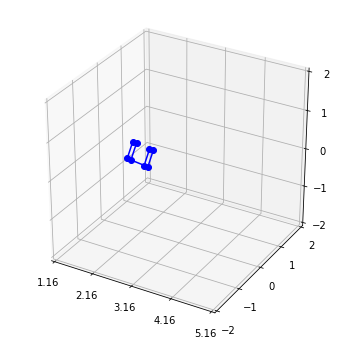

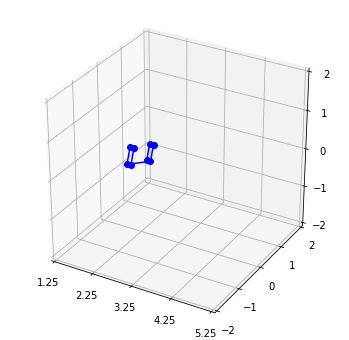

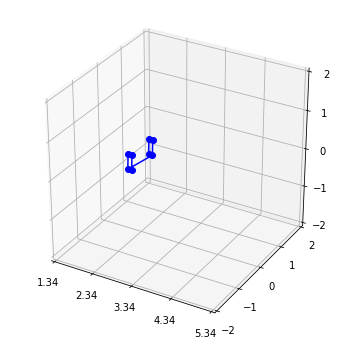

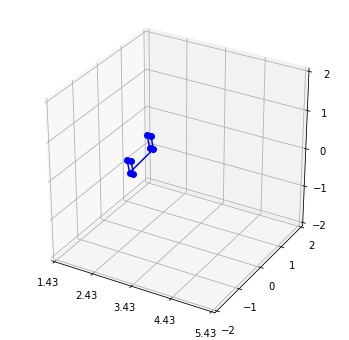

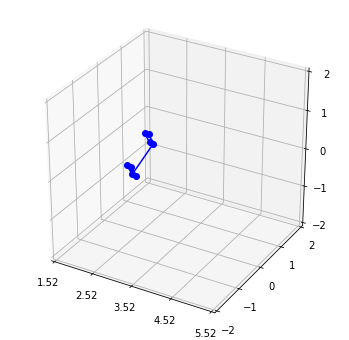

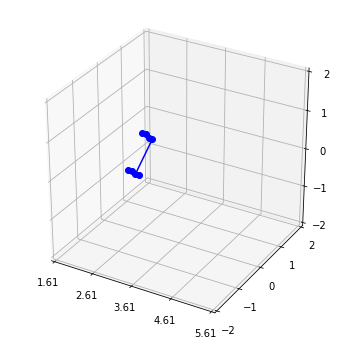

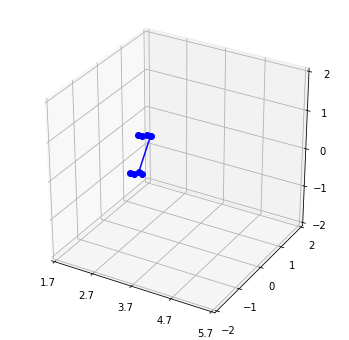

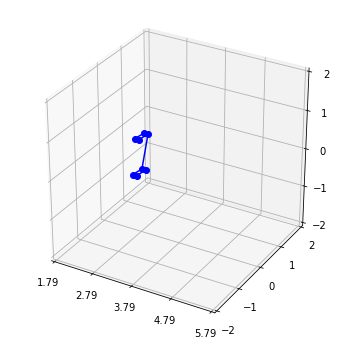

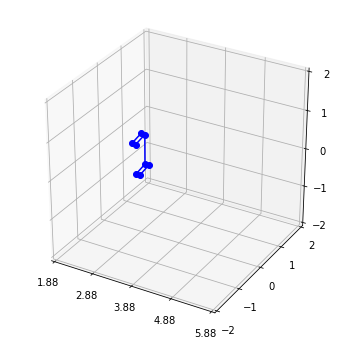

In [44]:
# screw motionのシミュレーション．並進＋X軸回りの回転．図を逐次書き出し．
# #inline
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
WAIST = 1;
R0=np.eye(3);
p0= [0,0,0];
mass = 10.0; 
AX=[-1.0, 3.]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

#uLINK = struct('name','BODY'    , 'm', 10, 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','q',0);
#uLINK.mother = 0;

#% Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

#[uLINK(1).vertex,uLINK(1).face]   = MakeBox([lx ly lz]  ,[lx/2 ly/2 lz/2] );    % BODY
wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
print("arr.vertex1 ", arr[1].vertex);
for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;
#print("arr.vertex2 ", arr[1].vertex);



#%% body state
#arr[WAIST]=uLINK("WAIST",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)
#uLINK(WAIST).p = [0, 0, 0]';
#uLINK(WAIST).R = eye(3);
arr[WAIST].w = [1, 0, 0]; #uLINK(WAIST).w  = [1, 0, 0]';
arr[WAIST].vo = [0.3, 0, 0]; # uLINK(WAIST).vo = [0.3 0 1]';
#arr[WAIST].vertex=[];

for n in range(len(arr)):
    arr[n].u = 0.0;

Dtime = 0.3;
time  = 10.0;
tsize = int(time//Dtime); # length(time);「//」は商だけ求める演算子
print("tsize ",tsize)
for n in range(tsize):
    DrawAllJoints(1);
    [arr[WAIST].p, arr[WAIST].R] = SE3exp(1, Dtime);       


tsize  33


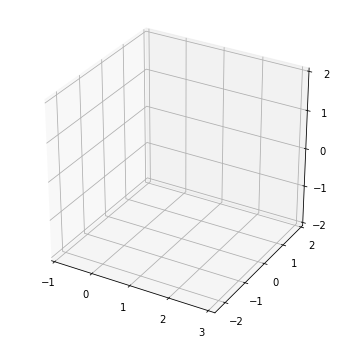

In [45]:
# screw のシミュレーション．並進移動vo = [0.3, 0, 1.0]＋x軸回りの回転w  = [1, 0, 0]
# アニメーション作成（screwmotion.gif）
#inline
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
WAIST = 1;
R0=np.eye(3);
p0= [0,0,0];
mass = 10.0; 
AX=[-1.0, 3.]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

#uLINK = struct('name','BODY'    , 'm', 10, 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','q',0);
#uLINK.mother = 0;

# Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])

for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;
#print("arr.vertex2 ", arr[1].vertex);



#%% body state
#arr[WAIST]=uLINK("WAIST",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)
#uLINK(WAIST).p = [0, 0, 0]';
#uLINK(WAIST).R = eye(3);
arr[WAIST].w = [1, 0, 0]; #uLINK(WAIST).w  = [1, 0, 0]'; # 角速度の初速
arr[WAIST].vo = [0.3, 0, 1.0]; # uLINK(WAIST).vo = [0.3 0 1]'; # 並進速度の初速
#arr[WAIST].vertex=[];

for n in range(len(arr)):
    arr[n].u = 0.0;

Dtime = 0.3;
time  = 10.0;
tsize = int(time//Dtime); # length(time);「//」は商だけ求める演算子
print("tsize ",tsize)
for n in range(tsize):
    #DrawAllJoints(1);
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3): # 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k]; #% adding x,y,z to all vertex
    im = ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ax.set_xticks(np.linspace(AX[0], AX[1], 5))
    ax.set_yticks(np.linspace(AY[0], AY[1], 5))
    ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
    ims.append(im)
    [arr[WAIST].p, arr[WAIST].R] = SE3exp(1, Dtime);       

    
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('screwmotion.gif', writer="pillow")
plt.show()


In [46]:
def hat(c):
    c_hat = np.array([[0, -c[2], c[1]], [c[2], 0., -c[0]], [-c[1], c[0], 0.]]);
    return c_hat
    

In [47]:
def SE3dynamics(j,f,tau):

    w_c = np.matmul(arr[j].R, arr[j].c) + arr[j].p;   # center of mass
    w_I = np.matmul(np.matmul(arr[j].R, arr[j].I),  arr[j].R.T);  # inertia in world frame
    c_hat = hat(w_c);
    Iww = w_I + arr[j].m * np.matmul(c_hat,  c_hat.T); 
    Ivv = arr[j].m * np.eye(3);
    Iwv = arr[j].m * c_hat;

    P = arr[j].m * (arr[j].vo + np.cross(arr[j].w, w_c));     #  linear  momentum
    L = arr[j].m * np.cross(w_c, arr[j].vo) + np.matmul(Iww, arr[j].w); #  angular momentum
    
    #pp = [];
    pp = np.hstack([np.cross(arr[j].w, P),
        np.cross(arr[j].vo,P) + np.cross(arr[j].w, L)]);
    pp = pp - np.hstack([f, tau]);   # 外力，外モーメントを加算
   
    Ia = np.vstack([np.hstack([Ivv, Iwv.T]), np.hstack([Iwv, Iww])]);
    #print("Iwv ", Iwv)
    #print("Ia ", Ia)
    a0 = -np.matmul(np.linalg.inv(Ia),  pp);
    #print("a0 ", a0)
    for k in range(3):
        arr[j].dvo[k] = a0[k];
        arr[j].dw[k] = a0[k+3];
      
    return P, L

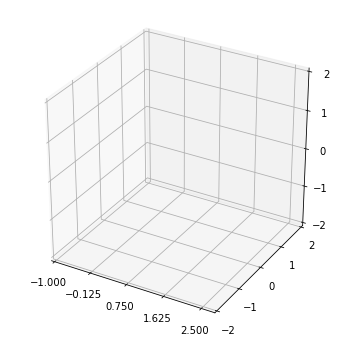

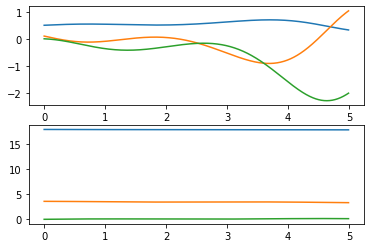

In [48]:
# rigidbody_fly 並進＋X,Z軸回りの回転
#inline
import numpy as np #行列計算のためnumpyをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
R0=np.eye(3);
p0= np.zeros(3);
mass = 36.0; 
AX=[-1.0, 2.5]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
#ax.set_xticks(np.linspace(AX[0], AX[1], 5))
#ax.set_yticks(np.linspace(AY[0], AY[1], 5))
#ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,mass,0,np.zeros(3),np.array([0.0, 0.0, 1.0]),0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
#uLINK = struct('name','BODY' , 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','mother',0);

# Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;


arr[BODY].I = np.array([[ 1/12*(ly*ly + lz*lz), 0., 0.],
            [0., 1/12*(lx*lx + lz*lz),  0],
            [0., 0., 1/12*(lx*lx + ly*ly)]]) * arr[BODY].m;
arr[BODY].c = np.array([0., 0., 0.]);
        
# initial state
arr[BODY].p = np.array([0.0, 0.0, 0.0]);
arr[BODY].R = np.eye(3);
arr[BODY].w = np.array([1., 0., 1.]); #回転ベクトル
arr[BODY].vo= np.array([0.5, 0.1, 0.]); #並進速度

Dtime   = 0.005;
EndTime = 5.0;
tsize  = int(EndTime//Dtime);
frame_skip = 60;

L_m = np.zeros((tsize,3));
P_m = np.zeros((tsize,3));
w_m = np.zeros((tsize,3));
vo_m = np.zeros((tsize,3));

for n in range(tsize):
    vo_m[n,:] = arr[BODY].vo;
    w_m[n,:] = arr[BODY].w;
    if n == 0:
        time = [0]
    else:
        time = np.hstack([time, n*Dtime])
    [P,L] = SE3dynamics(1, np.zeros(3), np.zeros(3));
    P_m[n,:] = P.T;
    L_m[n,:] = L.T;
    
    [arr[BODY].p, arr[BODY].R] = SE3exp(1, Dtime);
    arr[BODY].w = arr[BODY].w + Dtime * arr[BODY].dw;
    arr[BODY].vo= arr[BODY].vo+ Dtime * arr[BODY].dvo;
        
    if np.mod(n,frame_skip) == 1:
        #DrawAllJoints(1);
        vert = np.matmul(arr[1].R, arr[1].vertex.T);
        for k in range(3) :# 1:3
            vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex

        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
        im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
        ax.set_xticks(np.linspace(AX[0], AX[1], 5))
        ax.set_yticks(np.linspace(AY[0], AY[1], 5))
        ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
        ims.append(im);

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('rigidbody_fly.gif', writer="pillow")
plt.show()

fig = plt.figure();
ax = fig.add_subplot(2, 1, 1)
ax.plot(time, vo_m[:,0])
ax.plot(time, vo_m[:,1])
ax.plot(time, vo_m[:,2])
ax = fig.add_subplot(2, 1, 2)
ax.plot(time, P_m[:,0])
ax.plot(time, P_m[:,1])
ax.plot(time, P_m[:,2])
plt.show()

In [49]:
def MakeZcylinder(pos, radius,len):

    a = 10;    #% number of side faces

    for i in range(a):
        theta = i/a * 2*math.pi;
        if i == 0:
            x = np.array(radius*math.cos(theta))
            y = np.array(radius*math.sin(theta))
        x  = np.hstack([x, radius*math.cos(theta)]);
        y  = np.hstack([y, radius*math.sin(theta)]);

    z1 = len/2 * np.ones(a+1); #ones(1,a);
    z2 = -z1;
    #print("x ", x)
    #print("y ", y)
    #print("z1 ", z1)

    vert    = np.vstack([np.hstack([x, x, 0., 0.]),
            np.hstack([y, y, 0., 0.]),
            np.hstack([z1, z2, len/2., -len/2.])]);
    for n in range(3): # 1:3
        vert[n,:] = vert[n,:] + pos[n];
    
    #print("vert ", vert)
 
    #% make index data specifying polygons
    #face_side = [1:a; a+1:2*a; a+2:2*a a+1; 2:a 1];
    #face_up   = [1:a; 2:a 1];
    #face_up(3:4,:) = 2*a+1;  % index of up center
    #face_down = [a+2:2*a a+1; a+1:2*a];
    #face_down(3:4,:) = 2*a+2; % index of down center
    #face = [face_side face_up face_down];

    return vert


In [50]:
def MakeTop(j, r, a, c):
    pos = np.array([0., 0., c]);
    vertex1 = MakeZcylinder(pos, r, a);             # 円盤部の形状
    vertex2 = MakeZcylinder(pos, 0.01, 2*c); # 軸の形状
    vertex = np.hstack([vertex1, vertex2]);  # １つに合成
    arr[j].vertex = vertex.T;                # 転置しておいてShowObjectに渡せるようにしている．

    density = 2.7E+3;                     #  アルミニウムの比重　[kg/m^2]
    arr[j].m = math.pi*r*r*a*density;         # 円盤部の質量 [kg]
    arr[j].I = np.array([ [(a*a + 3*r*r)/12, 0., 0.],   
                [0., (a*a + 3*r*r)/12.,  0.],
                [0., 0., r*r/2]]) * arr[j].m;   # 円盤部の慣性テンソル
    arr[j].c = [0., 0., c];                 # 重心


In [51]:
def TopForce(j):
    w_c = np.matmul(arr[j].R, arr[j].c) + arr[j].p;   # 重心位置
    f = np.array([0., 0., -arr[j].m * G]);  # 重力
    t = np.cross(w_c, f);                   # 重力による原点回りモーメント

    if arr[j].p[2] < 0.0 : # 支点は床面と接触している
        Kf = 1.0E+4;      # 床面の剛性[N/m]
        Df = 1.0E+3;      # 床面の粘性[N/(m/s)]
        v = arr[j].vo + np.cross(arr[j].w, arr[j].p);  # 支点の速度
        fc = np.array([-Df*v[0],  -Df*v[1], -Kf*arr[j].p[2]-Df*v[2]]);
        f = f + fc;
        t = t + np.cross(arr[j].p, fc);

    return f,t

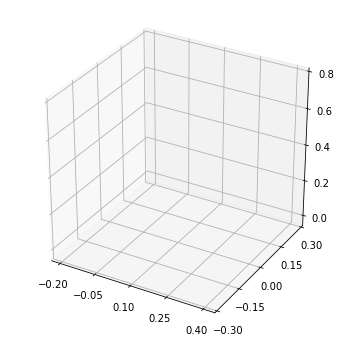

In [52]:
# top_simulation.m
# コマの運動のシミュレーション
#inline
import numpy as np #行列計算のためnumpyをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

R0=np.eye(3);
p0= [0,0,0];
BODY = 1;

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) 
#uLINK = struct('name','BODY' , 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','mother',0);

G = 9.8;
r = 0.2; a = 0.05; c = 0.2;#           % 円盤の半径,厚み，軸の長さ/2 [m]
MakeTop(1, r,a,c);


arr[1].p = np.array([0., 0., 0.3]);                # 初期位置 [m]
arr[1].R = Rodrigues([1., 0., 0.],math.pi/50.); # 初期姿勢
arr[1].vo= [0., 0., 0.];                 # 初速度 [m/s]
arr[1].w = [0., 0., 50.];                # 初期角速度 [rad/s]
Dtime   = 0.002;
EndTime = 2.0;
time  = int(EndTime//Dtime);
frame_skip = 3;

AX=[-0.2, 0.4];  AY=[-0.3, 0.3]; AZ=[0., 0.8];  # 3D表示範囲
for n in range(time):
    [f,tau] = TopForce(1);                           # 外力の計算
    [P,L]   = SE3dynamics(1,f,tau);                  # 加速度の計算    
    [arr[1].p, arr[1].R] = SE3exp(1, Dtime);     # 位置・姿勢の更新       
    arr[1].w = arr[1].w + Dtime * arr[1].dw;   # 角速度の更新
    arr[1].vo= arr[1].vo+ Dtime * arr[1].dvo;  # 速度の更新
    if np.mod(n,frame_skip) == 1 :
        # ShowObject(arr);                               # 表示
        vert = np.matmul(arr[1].R, arr[1].vertex.T);
        for k in range(3) :# 1:3
            vert[k,:] = vert[k,:] + arr[1].p[k];#   % adding x,y,z to all vertex
        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
        im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
        ax.set_xticks(np.linspace(AX[0], AX[1], 5))
        ax.set_yticks(np.linspace(AY[0], AY[1], 5))
        ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
        ims.append(im);

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('top_anim.gif', writer="pillow")
plt.show()

